# Calculating staff on-costs

This notebook captures a discussion on on-cost calculation for staff.

## Simple model

Firstly, a refresher, the ``ucamoncosts`` module implements a convenience function which can calculate total annual on-costs for a staff member:

In [1]:
import ucamstaffoncosts

ucamstaffoncosts.on_cost(25000, scheme=ucamstaffoncosts.Scheme.USS_EXCHANGE)

OnCost(salary=25000, exchange=-2000, employer_pension=6500, employer_nic=2011, apprenticeship_levy=115, total=31626)

So far, so simple. The complication comes when the staff member's salary changes over the year. Expected salary changes ocurr at different points of the year:

* On employment anniversary dates there is a spine point increase if the member still have non-contribution points available in their grade.
* On 1st August, we plan for a salary increase due to CPI of 2%.

In addition to this, changes in circumstance could cause salary change.

To make the code below simple, we will calculate an array of salaries for a staff member for each day of the (leap) tax year: let $S_i$ be the salary for day $i$ of the tax year where $i$ ranges between $0$ and $N-1$, and $t$ be the current day index.

In [2]:
import numpy as np

# Salaries for someone in a leap-year. The first day of this year is the first day of the tax year.
N = 366 # a leap year
S = np.zeros(N, dtype=np.int)
S[:30] = 25000
S[30:120] = 26000
S[120:220] = 27000
S[220:] = 28000

# "Now" is day 80 of the year.
t = 80

We can plot the salary of the staff member over the tax year:

In [3]:
# Enable plotting support
%pylab inline

Populating the interactive namespace from numpy and matplotlib


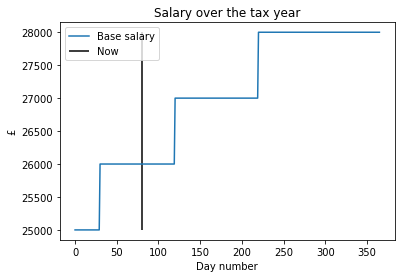

In [4]:
plot(S, label='Base salary')
vlines([t], S.min(), S.max(), label='Now')
xlabel('Day number'); ylabel('£'); title('Salary over the tax year'); legend(loc='best')
None # to suppress output of legend object's repr

The total taxable salary, $S'_T$ for the year is simply the sum of each daily salary:
$$
S'_N = \frac{1}{N} \sum_{0 \le i \lt N} S_i
$$

In [5]:
Sprime_N = S.sum() / N

We can use this total to calculate the total on-cost, $C_T$, for the year:

In [6]:
C_T = ucamstaffoncosts.on_cost(Sprime_N, scheme=ucamstaffoncosts.Scheme.USS_EXCHANGE).total
print(f'Total on-cost: {C_T:d}')

Total on-cost: 34235


In order to model expenditure and commitments, we weight the year by base salary earned up until that point. The base salary earned up to but not including day $t$, $S'_t$ is given by:
$$
S'_t = \frac{1}{N} \sum_{0 \le i \lt t} S_i
$$

In [7]:
Sprime_t = S[:t].sum() / N
print(f'Base earned salary so far: {Sprime_t:.0f}')

Base earned salary so far: 5601


Therefore the expenditure for the year, $E$ is
$$
\frac{S'_t}{S'_N} C_T
$$

In [8]:
E = (Sprime_t / Sprime_N) * C_T
print(f'Expenditure so far: {E:.0f}')

Expenditure so far: 7105


The expected commitment is simply the expected total on-cost minus the expenditure:

In [9]:
commitment = C_T - E
print(f'Commitment for remainder of year: {commitment:.0f}')

Commitment for remainder of year: 27130


Now, suppose that the staff member's contract ends on day $t'$ where $t' > t$. If we assume the staff member leaves the University at this date, we simply set $N = t'$ and perform the calculation above.

## Optimisations

Obviously the code above is non-optimal. There is no need to sum up salaries over days. We can simply record the change points and treat the salary as constant between them. A more efficient implementation is left as an exercise for the reader.